# **Build and train a Convolutional Neural Network to classify fruits in Amazon using TensorFlow and Keras.**

#Introduction to keras

In [2]:
import tensorflow as tf
print (tf.keras.__version__)

3.8.0


# Data Preparation

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Task 1: Data Understanding and Visualization:

**Load and visualize images from a dataset stored in directories, where each subdirectory represents a class.**

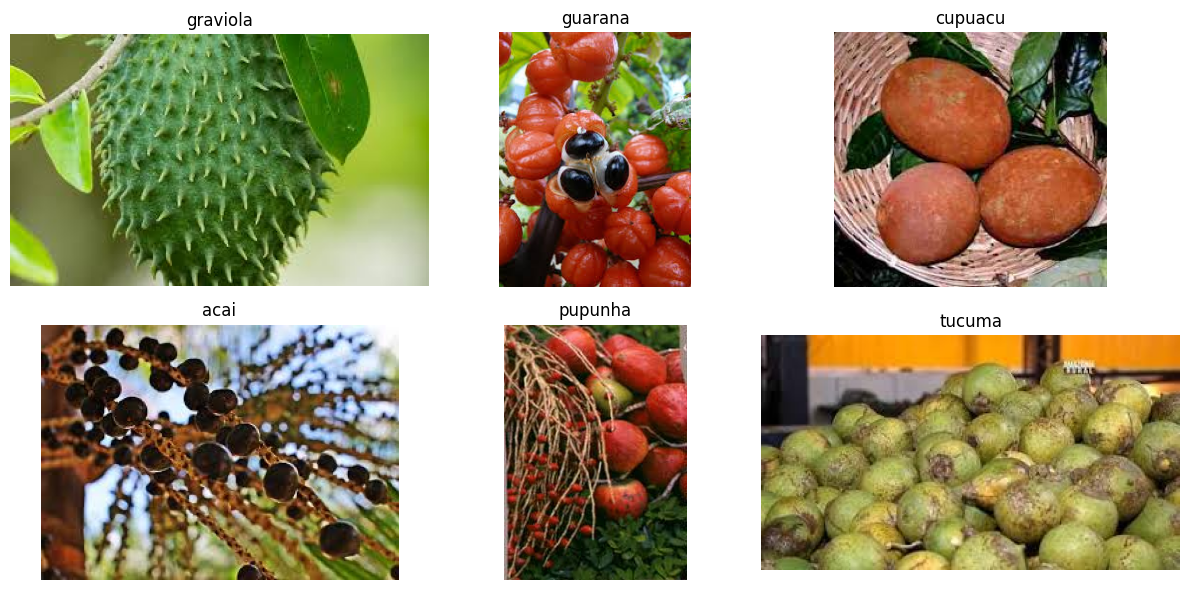

In [5]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the path to the dataset
train_dir = "/content/drive/MyDrive/AI and ML/FruitinAmazon/train"

# Get the list of class directories
class_names = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Select one random image from each class
selected_images = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    image_files = os.listdir(class_path)
    random_image = random.choice(image_files)
    selected_images.append((class_name, os.path.join(class_path, random_image)))

# Display the images in a grid format with two rows
fig, axes = plt.subplots(2, len(selected_images) // 2 + len(selected_images) % 2, figsize=(12, 6))

for ax, (class_name, image_path) in zip(axes.flat, selected_images):
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis("off")

plt.tight_layout()
plt.show()


**What did you Observe?**

Answer: I obeserved that ,it retrieves all class directories from the dataset then randomly selects one image from each class and displays them in a grid with two rows using Matplotlib.

**Check for Corrupted Image**

In [6]:
import os
from PIL import Image

# Define the path to the train directory
train_dir = "/content/drive/MyDrive/AI and ML/FruitinAmazon/train"

# List to store corrupted image paths
corrupted_images = []

# Iterate through each class subdirectory
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):  # Ensure it's a directory
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                with Image.open(image_path) as img:
                    img.verify()  # Check if the image is corrupted
            except (IOError, SyntaxError):
                corrupted_images.append(image_path)
                os.remove(image_path)  # Remove corrupted image
                print(f"Removed corrupted image: {image_path}")

# Print final message
if not corrupted_images:
    print("No Corrupted Images Found.")


No Corrupted Images Found.


# Task 2: Loading and Preprocessing Image Data in keras:

In [7]:
import tensorflow as tf

# Define image size and batch size
img_height = 128  # Example image height
img_width = 128   # Example image width
batch_size = 32
validation_split = 0.2  # 80% training, 20% validation

# Create a preprocessing layer for normalization
rescale = tf.keras.layers.Rescaling(1./255)  # Normalize pixel values to [0, 1]

# Create training dataset with normalization
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

# Apply normalization and prefetching for efficiency
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x, y: (rescale(x), y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Create validation dataset with normalization
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

# Apply normalization and prefetching for efficiency
val_ds = val_ds.map(lambda x, y: (rescale(x), y)).cache().prefetch(buffer_size=AUTOTUNE)


Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


# Task 3 - Implement a CNN with given Structure and Hyper - parameters:

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the CNN model
def create_cnn_model(num_classes, input_shape=(128, 128, 3)):
    model = keras.Sequential([
        # Convolutional Layer 1
        layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding="same", activation="relu", input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),

        # Convolutional Layer 2
        layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),

        # Flatten layer
        layers.Flatten(),

        # Fully Connected Layers (Hidden Layers)
        layers.Dense(64, activation="relu"),
        layers.Dense(128, activation="relu"),

        # Output Layer (Softmax for Multi-Class Classification)
        layers.Dense(num_classes, activation="softmax")
    ])

    return model

# Example usage
num_classes = 6  # Replace with the actual number of classes in your dataset
model = create_cnn_model(num_classes)
model.summary()  # Print model architecture


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Compile the model
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the callbacks
checkpoint_callback = ModelCheckpoint(
    'best_model.h5',               # File to save the best model
    monitor='val_loss',            # Monitor validation loss
    save_best_only=True,           # Save the best model
    mode='min',                    # We want to minimize the validation loss
    verbose=1                       # Print info when saving the model
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',            # Monitor validation loss
    patience=10,                   # Stop after 10 epochs without improvement
    restore_best_weights=True,     # Restore the best weights after stopping
    verbose=1                       # Print info when early stopping is triggered
)

# Train the model with the specified batch size, epochs, and callbacks
history = model.fit(
    train_ds,                      # Training dataset
    validation_data=val_ds,        # Validation dataset
    epochs=250,                    # Number of epochs
    batch_size=16,                 # Batch size
    callbacks=[checkpoint_callback, early_stopping_callback]  # Use callbacks
)


Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.1296 - loss: 1.8057
Epoch 1: val_loss improved from inf to 1.74258, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 855ms/step - accuracy: 0.1319 - loss: 1.8043 - val_accuracy: 0.2222 - val_loss: 1.7426
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.2278 - loss: 1.7801
Epoch 2: val_loss improved from 1.74258 to 1.72782, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 621ms/step - accuracy: 0.2229 - loss: 1.7816 - val_accuracy: 0.3889 - val_loss: 1.7278
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.2079 - loss: 1.7752
Epoch 3: val_loss improved from 1.72782 to 1.72175, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 393ms/step - accuracy: 0.2149 - loss: 1.7746 - val_accuracy: 0.7778 - val_loss: 1.7218
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.4433 - loss: 1.7609
Epoch 4: val_loss improved from 1.72175 to 1.70830, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 412ms/step - accuracy: 0.4227 - loss: 1.7621 - val_accuracy: 0.6667 - val_loss: 1.7083
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.5194 - loss: 1.7248
Epoch 5: val_loss improved from 1.70830 to 1.70163, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 936ms/step - accuracy: 0.4729 - loss: 1.7319 - val_accuracy: 0.6111 - val_loss: 1.7016
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.3775 - loss: 1.7400
Epoch 6: val_loss improved from 1.70163 to 1.70065, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step - accuracy: 0.3804 - loss: 1.7388 - val_accuracy: 0.5000 - val_loss: 1.7006
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.2782 - loss: 1.7312
Epoch 7: val_loss improved from 1.70065 to 1.67867, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step - accuracy: 0.2955 - loss: 1.7290 - val_accuracy: 0.6111 - val_loss: 1.6787
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.5370 - loss: 1.6523
Epoch 8: val_loss improved from 1.67867 to 1.64848, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step - accuracy: 0.4931 - loss: 1.6658 - val_accuracy: 0.6111 - val_loss: 1.6485
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.3495 - loss: 1.6818
Epoch 9: val_loss improved from 1.64848 to 1.63046, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 412ms/step - accuracy: 0.3524 - loss: 1.6806 - val_accuracy: 0.5556 - val_loss: 1.6305
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.3146 - loss: 1.6731
Epoch 10: val_loss improved from 1.63046 to 1.57790, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 438ms/step - accuracy: 0.3297 - loss: 1.6696 - val_accuracy: 0.7222 - val_loss: 1.5779
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.4787 - loss: 1.5588
Epoch 11: val_loss improved from 1.57790 to 1.56373, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step - accuracy: 0.4493 - loss: 1.5796 - val_accuracy: 0.6111 - val_loss: 1.5637
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.5380 - loss: 1.5157
Epoch 12: val_loss improved from 1.56373 to 1.53427, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step - accuracy: 0.5007 - loss: 1.5396 - val_accuracy: 0.6111 - val_loss: 1.5343
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.3947 - loss: 1.5865
Epoch 13: val_loss improved from 1.53427 to 1.39597, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 745ms/step - accuracy: 0.3967 - loss: 1.5820 - val_accuracy: 0.5556 - val_loss: 1.3960
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.5417 - loss: 1.4023
Epoch 14: val_loss did not improve from 1.39597
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 752ms/step - accuracy: 0.5000 - loss: 1.4354 - val_accuracy: 0.5000 - val_loss: 1.4787
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.5602 - loss: 1.3918
Epoch 15: val_loss did not improve from 1.39597
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step - accuracy: 0.5278 - loss: 1.4252 - val_accuracy: 0.5556 - val_loss: 1.4428
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.4502 - loss: 1.4400
Epoch 16: val_loss did not improve from 1.39597
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step - accuracy: 0.4488 - loss: 1.4412 - val_accuracy: 0.2778 - val_loss: 1.4630
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.6556 - loss: 1.2635
Epoch 17: val_loss improved from 1.39597 to 1.21216,

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step - accuracy: 0.5958 - loss: 1.3073 - val_accuracy: 0.5556 - val_loss: 1.2122
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.3640 - loss: 1.5476
Epoch 18: val_loss did not improve from 1.21216
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step - accuracy: 0.3702 - loss: 1.5363 - val_accuracy: 0.4444 - val_loss: 1.4482
Epoch 19/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.3463 - loss: 1.4093
Epoch 19: val_loss improved from 1.21216 to 1.01412, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step - accuracy: 0.3569 - loss: 1.4023 - val_accuracy: 0.6667 - val_loss: 1.0141
Epoch 20/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.6824 - loss: 1.0981
Epoch 20: val_loss did not improve from 1.01412
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step - accuracy: 0.6299 - loss: 1.1527 - val_accuracy: 0.1667 - val_loss: 1.9583
Epoch 21/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 0.4407 - loss: 1.2747
Epoch 21: val_loss did not improve from 1.01412
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4174 - loss: 1.3217 - val_accuracy: 0.6111 - val_loss: 1.1659
Epoch 22/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.7102 - loss: 1.0122
Epoch 22: val_loss did not improve from 1.01412
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 586ms/step - accuracy: 0.6715 - loss: 1.0597 - val_accuracy: 0.2222 - val_loss: 1.5820
Epoch 23/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.5852 - loss: 1.0606
Epoch 23: val_loss did not improve from 1.01412
3/3 ━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 692ms/step - accuracy: 0.6694 - loss: 0.9355 - val_accuracy: 0.5556 - val_loss: 0.9859
Epoch 28/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 0.6204 - loss: 0.9412
Epoch 28: val_loss did not improve from 0.98586
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5868 - loss: 0.9865 - val_accuracy: 0.6111 - val_loss: 1.2397
Epoch 29/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.6359 - loss: 1.0203
Epoch 29: val_loss did not improve from 0.98586
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 474ms/step - accuracy: 0.6366 - loss: 1.0127 - val_accuracy: 0.6667 - val_loss: 1.1674
Epoch 30/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.6873 - loss: 0.8962
Epoch 30: val_loss did not improve from 0.98586
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step - accuracy: 0.6856 - loss: 0.8938 - val_accuracy: 0.6667 - val_loss: 1.0541
Epoch 31/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.7199 - loss: 0.8247
Epoch 31: val_loss did not improve from 0.98586
3/3 ━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step - accuracy: 0.7854 - loss: 0.6915 - val_accuracy: 0.6667 - val_loss: 0.9196
Epoch 34/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.8454 - loss: 0.5826
Epoch 34: val_loss improved from 0.91962 to 0.85672, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step - accuracy: 0.8181 - loss: 0.6465 - val_accuracy: 0.6111 - val_loss: 0.8567
Epoch 35/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.7188 - loss: 0.8700
Epoch 35: val_loss improved from 0.85672 to 0.81438, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 387ms/step - accuracy: 0.7266 - loss: 0.8542 - val_accuracy: 0.7222 - val_loss: 0.8144
Epoch 36/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.8500 - loss: 0.4964
Epoch 36: val_loss improved from 0.81438 to 0.74206, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8250 - loss: 0.5604 - val_accuracy: 0.7222 - val_loss: 0.7421
Epoch 37/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.6209 - loss: 1.1789
Epoch 37: val_loss improved from 0.74206 to 0.61736, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 654ms/step - accuracy: 0.6150 - loss: 1.1904 - val_accuracy: 0.7778 - val_loss: 0.6174
Epoch 38/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.6824 - loss: 0.8837
Epoch 38: val_loss did not improve from 0.61736
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 417ms/step - accuracy: 0.6924 - loss: 0.8652 - val_accuracy: 0.5000 - val_loss: 1.2778
Epoch 39/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.8944 - loss: 0.4605
Epoch 39: val_loss did not improve from 0.61736
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step - accuracy: 0.8792 - loss: 0.5036 - val_accuracy: 0.5556 - val_loss: 1.0853
Epoch 40/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.6458 - loss: 0.9259
Epoch 40: val_loss did not improve from 0.61736
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 387ms/step - accuracy: 0.6406 - loss: 0.9343 - val_accuracy: 0.6667 - val_loss: 0.9929
Epoch 41/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.7963 - loss: 0.5276
Epoch 41: val_loss did not improve from 0.61736
3/3 

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 784ms/step - accuracy: 0.7834 - loss: 0.7018 - val_accuracy: 0.8889 - val_loss: 0.5325
Epoch 44/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8271 - loss: 0.6122
Epoch 44: val_loss did not improve from 0.53255
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 494ms/step - accuracy: 0.8391 - loss: 0.5960 - val_accuracy: 0.7222 - val_loss: 0.9655
Epoch 45/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9488 - loss: 0.4140
Epoch 45: val_loss did not improve from 0.53255
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step - accuracy: 0.9373 - loss: 0.4182 - val_accuracy: 0.8889 - val_loss: 0.7129
Epoch 46/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.8833 - loss: 0.4443
Epoch 46: val_loss did not improve from 0.53255
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 384ms/step - accuracy: 0.8813 - loss: 0.4433 - val_accuracy: 0.8333 - val_loss: 0.8411
Epoch 47/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.8704 - loss: 0.4924
Epoch 47: val_loss did not improve from 0.53255
3/3 

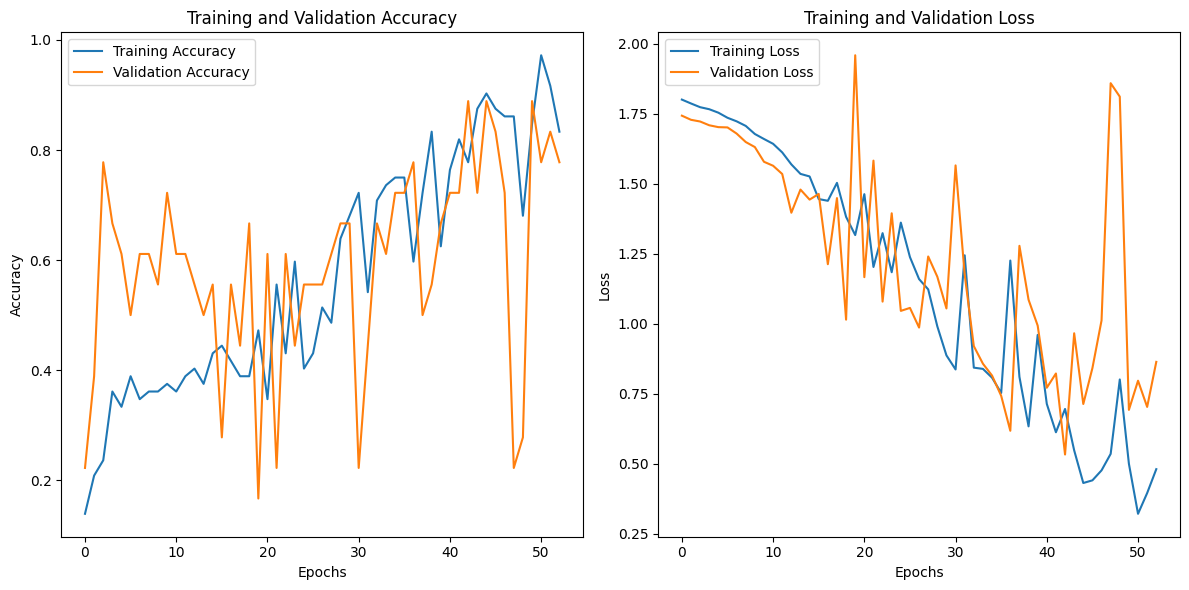

In [11]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
# Define the path to the test dataset directory
test_dir = "/content/drive/MyDrive/AI and ML/FruitinAmazon/test"

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,  # Directory where your test images are stored
    labels='inferred',
    label_mode='categorical',  # Use 'categorical' if you one-hot encoded labels
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle the test set
    seed=123
)
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_ds)

# Print the test loss and accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4%}")  # Convert accuracy to percentage


Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.2000 - loss: 271.5171
Test Loss: 271.5171
Test Accuracy: 20.0000%


# Save the trained model

In [14]:
# Save the trained model to an .h5 file
model.save("/content/drive/MyDrive/AI and ML Workshop/Week-5/FruitinAmazon/best_model_2358158.h5")


# Loading the best model and evaluation of the model on test set

In [15]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/AI and ML Workshop/Week-5/FruitinAmazon/best_model_2358158.h5")
print("Model loaded from best_model.h5")

# 3. Evaluate the loaded model on the test set
test_loss, test_accuracy = loaded_model.evaluate(test_ds)

# 4. Print the test results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Model loaded from best_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step - accuracy: 0.2000 - loss: 271.5171
Test Loss: 271.51708984375
Test Accuracy: 0.20000000298023224


In [16]:
import numpy as np
from sklearn.metrics import classification_report

# 1. Make predictions on the test set
predictions = loaded_model.predict(test_ds)

# 2. Convert probabilities to class labels (e.g., digits)
predicted_labels = np.argmax(predictions, axis=-1)

# 3. Get true labels from the test dataset
# Convert one-hot encoded true labels to class labels
true_labels = np.concatenate([np.argmax(y.numpy(), axis=-1) for x, y in test_ds], axis=0)

# 4. Generate the classification report
report = classification_report(true_labels, predicted_labels)

# 5. Print the classification report
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.21      0.60      0.32         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.18      0.40      0.25         5

    accuracy                           0.20        30
   macro avg       0.23      0.20      0.15        30
weighted avg       0.23      0.20      0.15        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
